

### Assumptions:

There is an 2D power spectral envelope that captures the time evolution and and spatial evolution of a telescope. For this study each spatial mode is assumed to be a zernike and the time evolution of each Zernike is assumed to be uncorrelated (which is conservative, a smart control system could learn the correlations of the system and correct better).




In [4]:
import numpy as xp
import astropy.io.fits as fits
import git
import os
from astropy.time import Time
dir_path = os.path.dirname(os.path.realpath("ZernikeEnvelope.ipynb"))
print(dir_path)
repo = git.Repo(search_parent_directories=True)
sha = repo.head.object.hexsha
print(sha)

/Users/edouglas/github/CDEEP/wcc_design/sims
71157a7eade8dd4da4a7979269330aee2acc0d14


In [5]:
from labellines import labelLines
from scipy import signal 

import astropy.units as u
import matplotlib.pyplot as plt

import poppy
from WFE_timeseries import * 


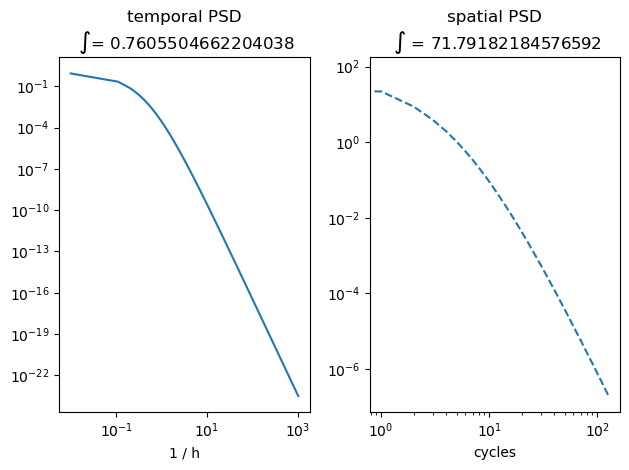

In [6]:
T=40*u.hour
np=xp


pixelscale=1*u.second
f_step=.1
freq=np.arange(0.01,1024,f_step)*1/u.hour # ~ 1Hz through 1 KHz
samplerate=freq[-1]/u.second
zerns=np.arange(128)
screen_size=freq.size
N=screen_size

psd=kneePSD(freq,1, .45/u.hour, 7)


initial_rms_WFE=40#*u.nm
Amp=np.sqrt(2)*initial_rms_WFE*u.nm #zernike amplitude


zerns_size=zerns.size

spatial_psd=kneePSD(zerns,10, 5, 6)
spatial_psd *= np.sqrt(initial_rms_WFE/spatial_psd.std())

psd_random = xp.random.RandomState()
psd_random.seed(123)

plt.subplot(121)

plt.plot(freq,psd)
plt.title("temporal PSD\n $\int$= {}".format(((np.trapz(psd)))))

plt.yscale("log")
plt.xscale("log")
plt.xlabel(freq.unit)

plt.subplot(122)
plt.plot(spatial_psd,"--")
plt.yscale("log")
plt.xscale("log")
plt.xlabel("cycles")
plt.title("spatial PSD\n $\int$ = {}".format(((np.trapz(spatial_psd)))))
plt.tight_layout()

In [7]:
fs=N/T
ts=1/fs
t_steps=ts*np.arange(N)

## 1D testing

0.9982544911122397
0.9982544911122397


/Users/edouglas/miniconda3/envs/astroconda/lib/python3.11/site-packages/matplotlib/cbook/__init__.py:1335: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


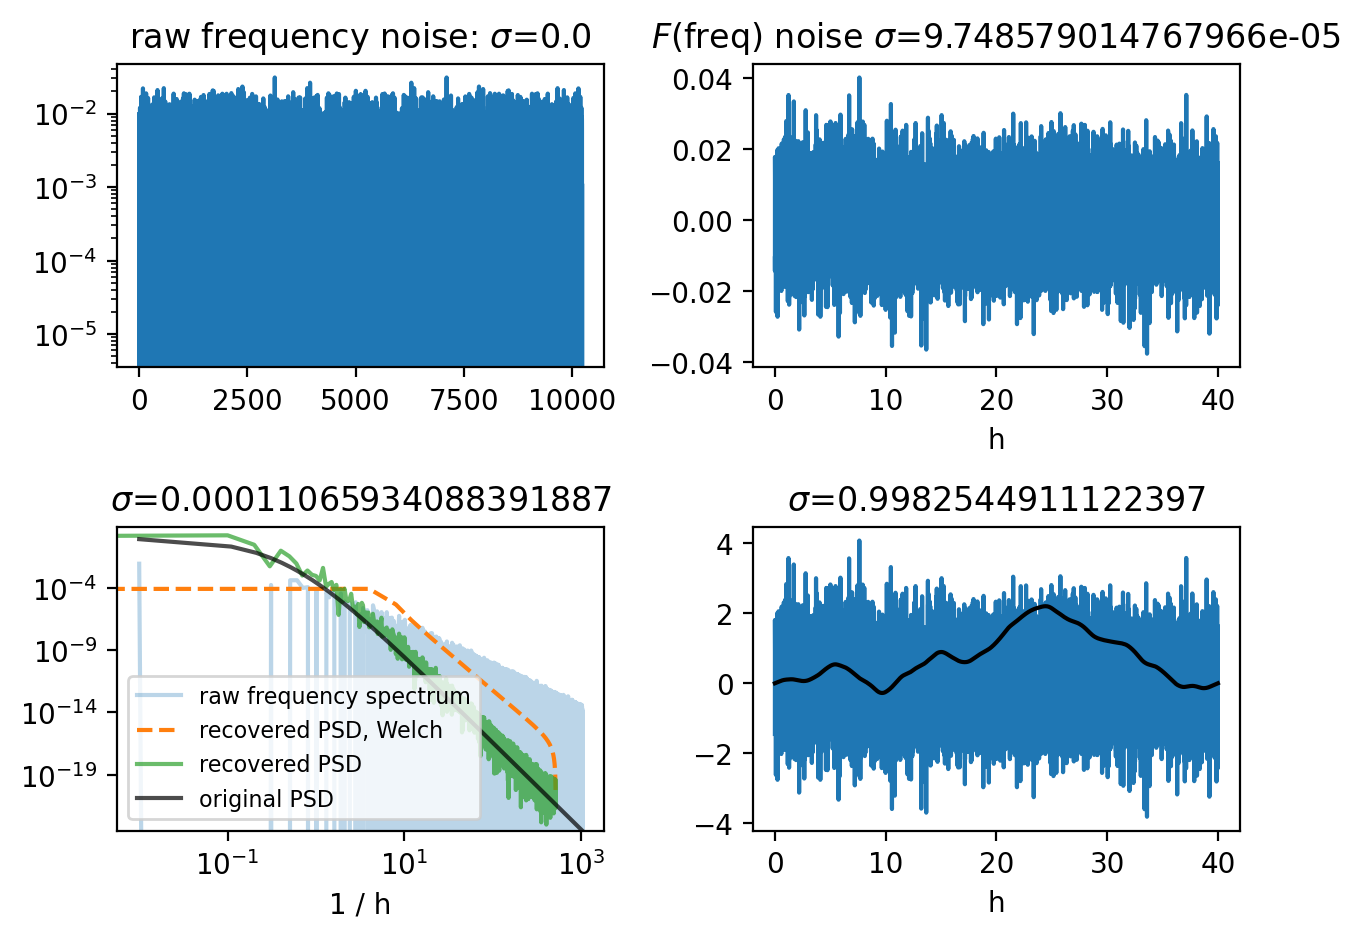

In [8]:
#test 1D generation of a time series from PSD
import copy

time_noise=psd_random.normal(loc=0,size=(screen_size )) 
orig_time_noise=copy.deepcopy(time_noise)
print(orig_time_noise.std())
#calculate F(x(t))/N
freq_noise1 = xp.fft.fftn(time_noise)/time_noise.size 
#rndm_noise1=rndm_noise1
fs_steps=fs*np.arange(N)

plt.figure(dpi=200)
plt.subplot(221)
plt.plot(freq_noise1)
plt.title("raw frequency noise: $\sigma$={}".format(np.round(np.std(freq_noise1))))
plt.yscale("log")
#plt.scale("log")
plt.subplot(222)
plt.xlabel(t_steps.unit)

plt.plot(t_steps,xp.fft.fftn(freq_noise1)/np.sqrt(time_noise.size))
plt.title("$F$(freq) noise $\sigma$={}".format(np.array(np.std(xp.fft.fftn(freq_noise1/time_noise.size)))))

plt.subplot(223)

##
##multiply noise PSD by desired PSD and then measure the resulting PSD to make sure it's what was expected
psd_scaled1 = (xp.sqrt(psd/(pixelscale.value**2)) * freq_noise1)
plt.title("$\sigma$={}".format(np.array(np.std(psd_scaled1))))

plt.loglog(freq,psd_scaled1,label="raw frequency spectrum",alpha=.3)

filtered_time_noise=xp.fft.fftn(psd_scaled1)*np.sqrt(N)

meas_psd=signal.welch(np.real(filtered_time_noise),fs=f_step*screen_size,
                      return_onesided=True,
                      #caling="spectrum",
                      )#,#,fs=screen_size*2
plt.plot(meas_psd[0],meas_psd[1],"--",label="recovered PSD, Welch")

meas_psd=signal.periodogram(np.real(filtered_time_noise),fs=f_step*screen_size)
plt.plot(meas_psd[0],meas_psd[1],alpha=.7,label="recovered PSD")
filtered_time_noise=xp.fft.fftn(psd_scaled1)*np.sqrt(time_noise.size)

plt.loglog(freq,(psd),label="original PSD",color='black',alpha=.7)

plt.ylim([psd.min(),psd.max()*10])
plt.xlabel(freq.unit)
plt.legend(fontsize=8,loc="lower left")
plt.subplot(224)
#transform new PSD into a time series
zeroed_time_noise=(orig_time_noise[::-1])/orig_time_noise.std()

plt.plot(t_steps,zeroed_time_noise)
zeroed_filtered_noise=(filtered_time_noise-filtered_time_noise[::-1][0])*orig_time_noise.std()/filtered_time_noise.std()
plt.plot(t_steps,zeroed_filtered_noise,
         color="black")
plt.title("$\sigma$={}".format(np.array(np.std(zeroed_filtered_noise))))
print(zeroed_filtered_noise.std())
plt.xlabel(t_steps.unit)

plt.tight_layout()

# Generate array of time series for each mode

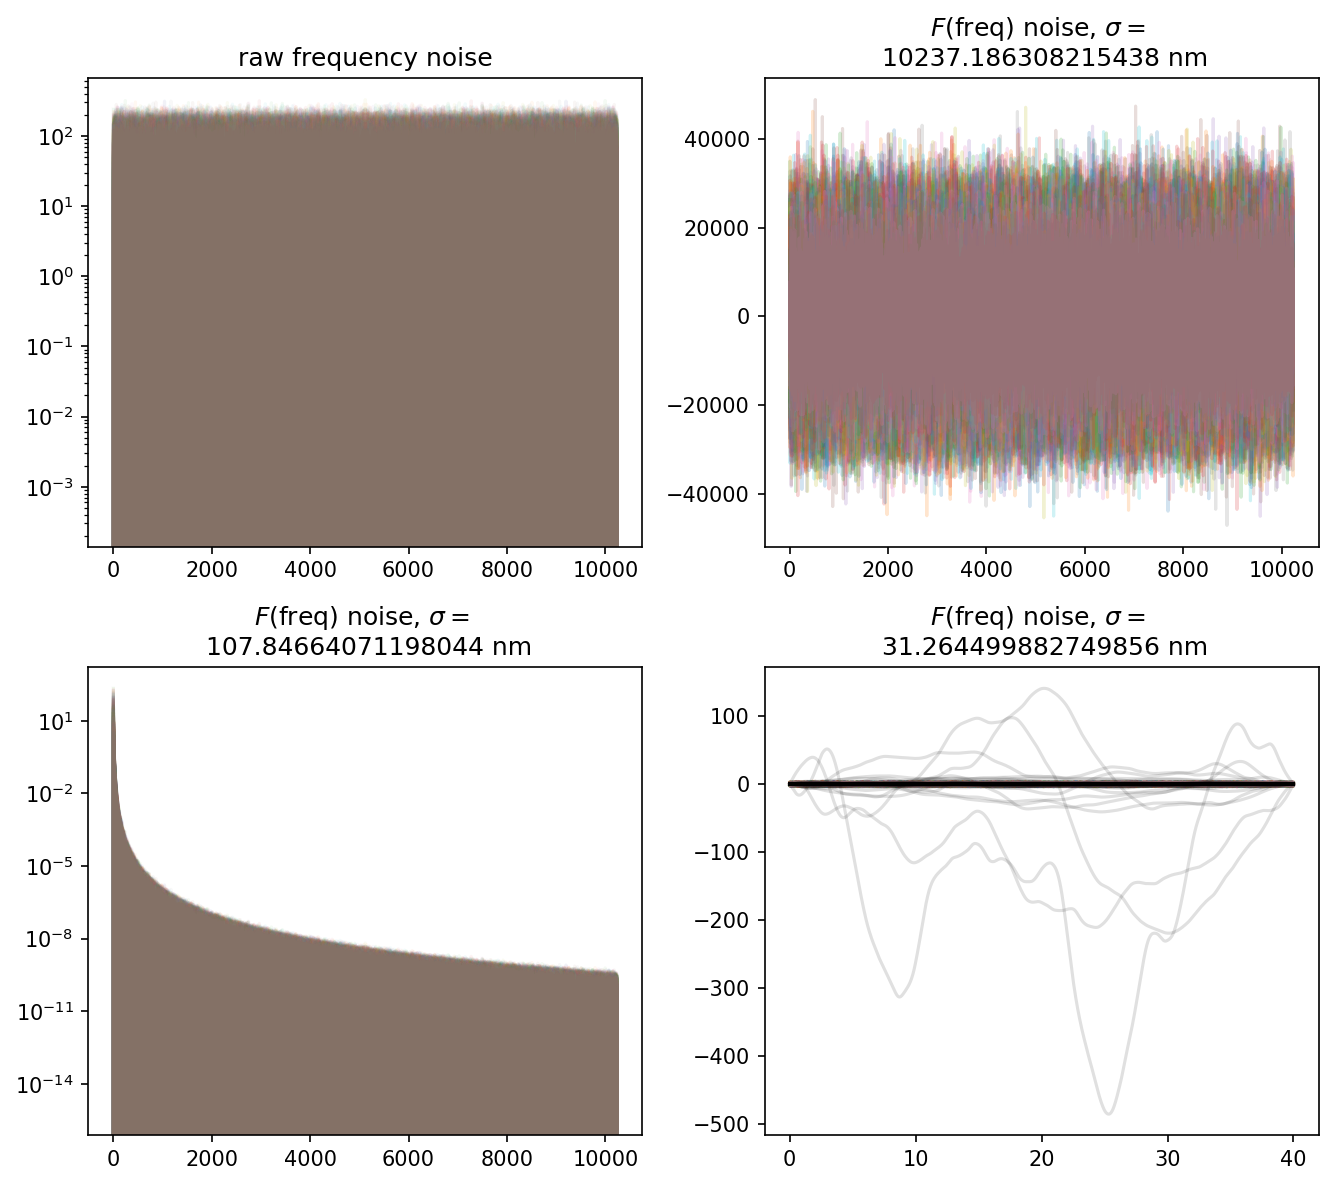

In [9]:
#test 2D generation of a time series from PSD
import copy

time_noise=psd_random.normal(loc=0,size=(screen_size,zerns_size))*u.nm
orig_time_noise=time_noise#copy.deepcopy(time_noise)
freq_noise1 = xp.fft.fftn(time_noise,axes=[0])
#rndm_noise1=rndm_noise1

plt.figure(dpi=150,figsize=[9,8])
plt.subplot(221)
plt.plot(freq_noise1,alpha=0.05)

plt.title("raw frequency noise")
plt.yscale("log")
#plt.scale("log")

plt.subplot(222)
plt.title("$F$(freq) noise, $\sigma=$ \n {}".format(np.std(xp.fft.fftn(freq_noise1,
                                                                       axes=[0]))))
plt.plot(xp.fft.fftn(freq_noise1,axes=[0]),alpha=0.2)

plt.subplot(223)
psd_scaled1 = np.einsum("ij,i->ij", 
                        freq_noise1,
                        xp.sqrt(psd/(pixelscale.value**2))) 
#https://stackoverflow.com/a/64722529/2142498
plt.plot(psd_scaled1,alpha=0.05)
plt.title("$F$(freq) noise, $\sigma=$ \n {}".format(np.std(xp.fft.fftn(psd_scaled1,axes=[0]))))

plt.yscale("log")

plt.subplot(224)
filtered=xp.fft.fftn(psd_scaled1,axes=[0])*np.sqrt(N)

filtered = np.einsum('ab,b->ab', filtered,
                                xp.sqrt(spatial_psd/(pixelscale.value**2))) #https://obilaniu6266h16.wordpress.com/2016/02/04/einstein-summation-in-numpy/
filtered *= Amp/filtered.std()
filtered=filtered-filtered[0,:]
plt.plot(t_steps,(orig_time_noise[::-1]-orig_time_noise.mean())/orig_time_noise.std(),alpha=0.2)
plt.plot(t_steps,filtered,
         alpha=0.12,color="black")
plt.title("$F$(freq) noise, $\sigma=$ \n {}".format(np.std(filtered)))

plt.tight_layout()


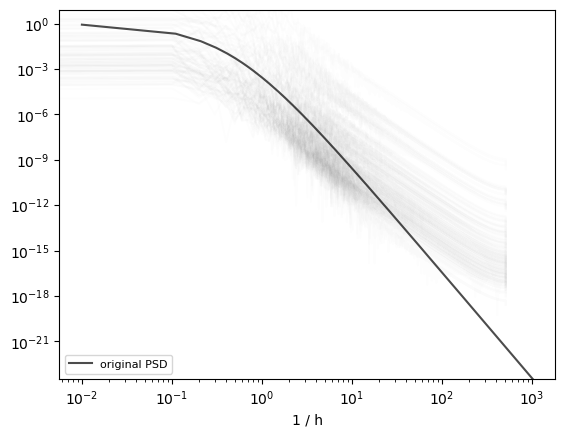

In [10]:




for i in range(zerns_size):
    meas_psd=signal.periodogram(np.abs(filtered[:,i]),fs=f_step*N)
    meas_psdW=signal.welch(np.abs(filtered[:,i]),fs=f_step*N,
                      return_onesided=True,
                      #caling="spectrum",
                      )#,#,fs=screen_size*2
    #plt.plot(meas_psdW[0],meas_psdW[1],"--",alpha=0.09)#,label="recovered PSD, Welch")
    plt.plot(meas_psd[0],meas_psd[1],alpha=.008,color="black")#,label="recovered PSD")


plt.loglog(freq,(psd),label="original PSD",color='black',alpha=.7)

plt.ylim([psd.min(),psd.max()*10])
plt.xlabel(freq.unit)
plt.legend(fontsize=8,loc="lower left")


Text(0.5, 1.0, 'filtered($t-t_0$)')

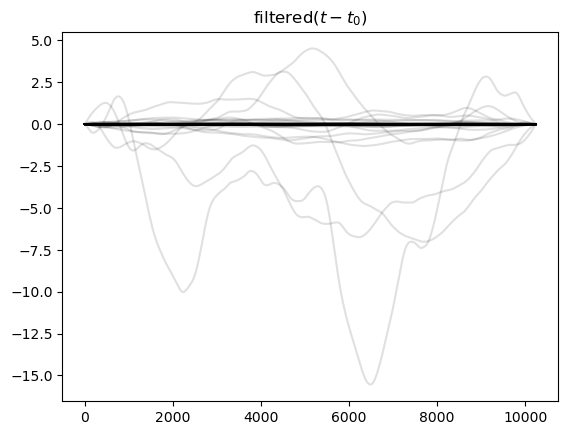

In [11]:
#plt.imshow(np.log(np.abs(filtered_time_space)))
plt.plot(np.real(filtered-filtered[0,:])*orig_time_noise.std()/filtered.std(),alpha=0.12,color="black")
plt.title("filtered($t-t_0$)")

/Users/edouglas/miniconda3/envs/astroconda/lib/python3.11/site-packages/labellines/core.py:148: UserWarning: Tried to label line Line2D(_child1), but could not find a label for it.
  warnings.warn(


[Text(36.858734330589904, 0.0023570948489984155, '6.0 nm / s(1/2)')]

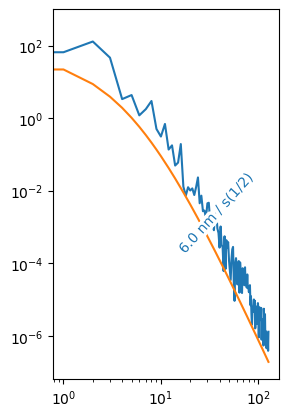

In [12]:

ax=plt.subplot(121)

filtered_power=filtered.std(axis=0)**2/(zerns_size*pixelscale)
plt.loglog(filtered_power,label=np.round(np.sqrt(np.std(filtered_power))))
plt.plot(spatial_psd)
labelLines(ax.get_lines(), )

#ax=plt.subplot(122)
#filtered_power=filtered.std(axis=1)**2/zerns_size
#plt.loglog(filtered_power,label=np.round(np.std(filtered_power)))
#labelLines(ax.get_lines(), )



## Compare to a STOP analyis

Text(0.5, 1.0, 'STOP model vs assumed PSD')

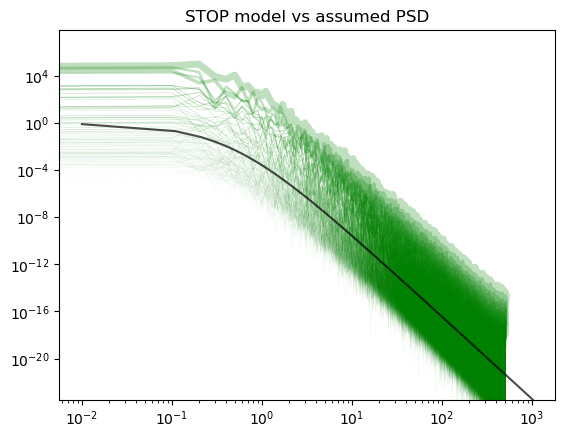

In [13]:

plt.figure(dpi=100)



for zern in range(zerns_size):
    meas_psd=signal.periodogram(np.real(filtered[:,zern]),fs=f_step*N)
    meas_psdW=signal.welch(np.real(filtered[:,zern]),fs=f_step*N,
                      return_onesided=True,
                      #caling="spectrum",
                      )#,#,fs=screen_size*2
    #plt.plot(meas_psdW[0],meas_psdW[1],"--",color="green",linewidth=5/(zern+1),)#,label="recovered PSD, Welch")
    plt.plot(meas_psd[0],meas_psd[1],color="green",linewidth=5/(zern+1),alpha=0.25)#,label="recovered PSD")


plt.loglog(freq,(psd),label="original PSD",color='black',alpha=.7)
plt.ylim([psd.min(),psd.max()*1e8])
plt.title("STOP model vs assumed PSD")

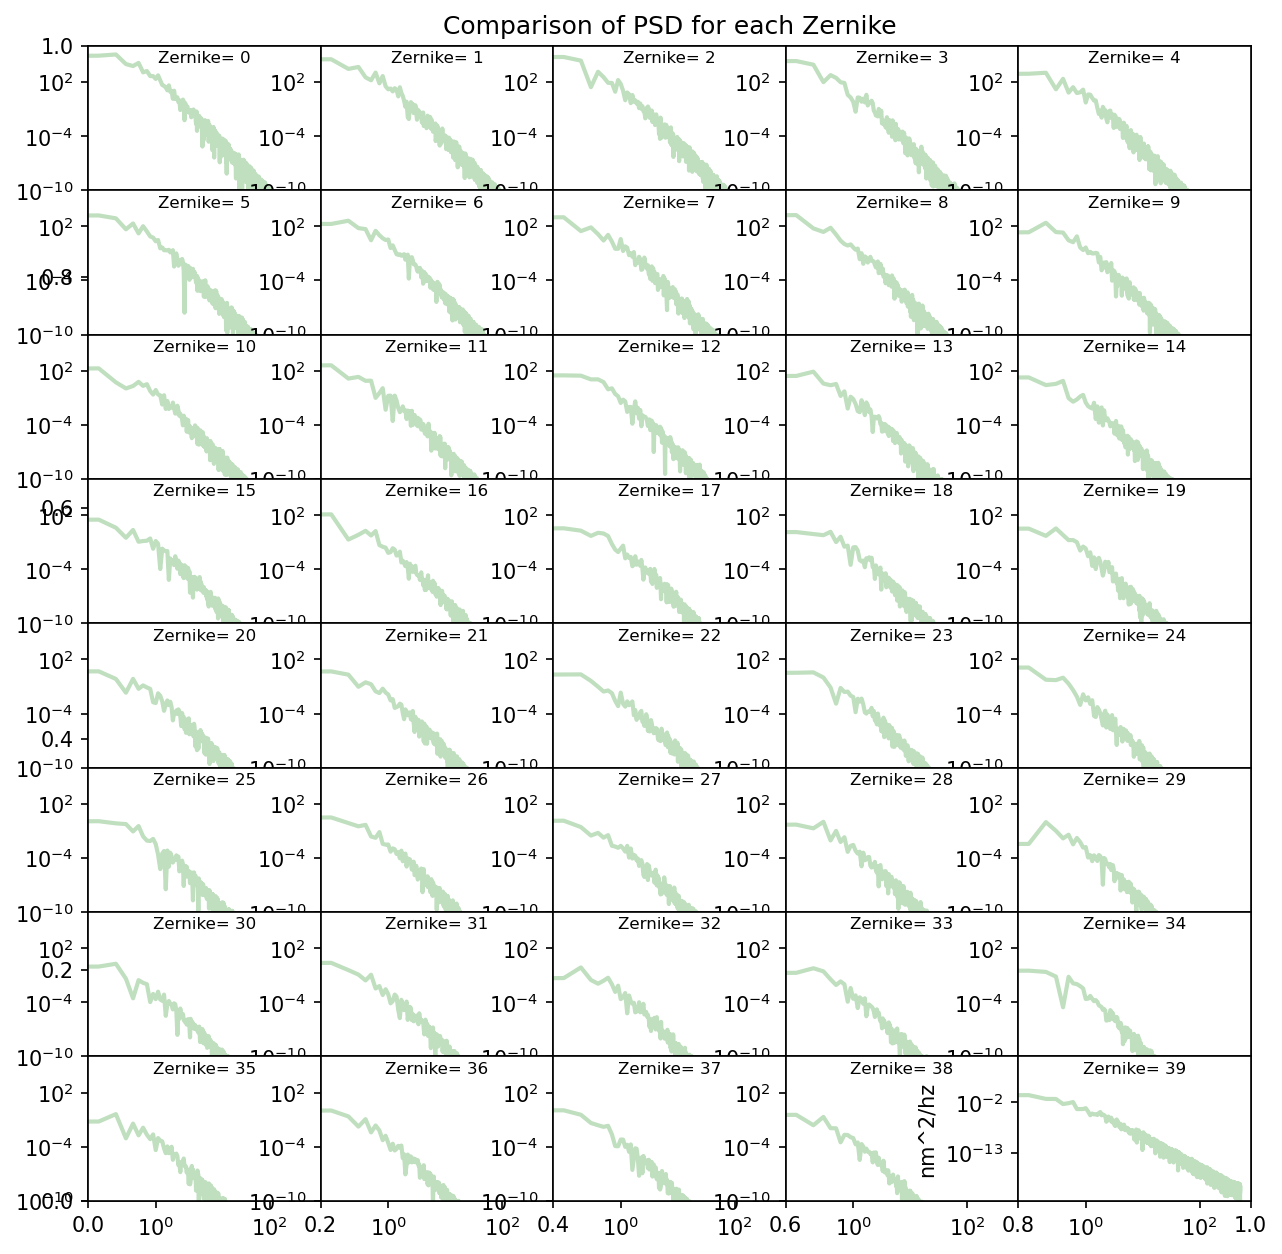

In [16]:

fig=plt.figure(dpi=150,figsize=[10,10])
plt.title("Comparison of PSD for each Zernike")
gs = fig.add_gridspec(8,5, wspace=0, hspace=0)
#axs = outer_grid.subplots()  # Create all subplots for the inner grid.


for zern in range(gs.ncols*gs.nrows):
        try:
            ax=fig.add_subplot(gs[zern])
        except Exception as err:
            print(err)
        ax.set_ylim([1e-10,1e6])
        meas_psd=signal.periodogram(np.real(filtered[:,zern]),fs=f_step*N)
        meas_psdW=signal.welch(np.real(filtered[:,zern]),fs=f_step*N,
                      return_onesided=True,
                      #caling="spectrum",
                      )#,#,fs=screen_size*2
        #plt.plot(meas_psdW[0],meas_psdW[1],"--",color="green",linewidth=5/(zern+1),)#,label="recovered PSD, Welch")
        plt.loglog(meas_psd[0],meas_psd[1],color="green",linewidth=2,alpha=0.25)#,label="recovered PSD")
        plt.title("Zernike= "+str(zern),fontsize=8, y=1.0, pad=-8)

#plt.plot(freq,psd,label="original PSD")
#plt.loglog(f2, Pxx_den*.001)
plt.ylabel("nm^2/hz")


#plt.loglog(freq,(psd),label="original PSD",color='black',alpha=.7)
plt.ylim([psd.min(),psd.max()*1e8])
plt.savefig("STOPvsFake.png",bbox_inches="tight")

# generate zernike basis


# generate time series of wavefronts with each Zernike included

In [18]:

zerns=poppy.zernike.zernike_basis(nterms=zerns_size, npix=256, rho=None, theta=None,)

WFE_timeseries = fits.HDUList([fits.PrimaryHDU(np.zeros([screen_size,zerns.shape[2],zerns.shape[1]]))])

for i in range(screen_size):
    '''einsum explainer:
    zerns have 3 dimensions, c,x,y
     we want to multiply the two arrays and sum away the c (zernike coefficient axis)
    so we omit the c dimension from the output and it gets summed
    '''
    WFE_timeseries[0].data[i,:,:] = np.einsum('cxy,c->xy', zerns[3:-1],np.abs(filtered[i,3:-1]))
    '''plt.figure()
    plt.imshow(WFE_timeseries[0].data[i,:,:],cmap="gnuplot",vmin=np.nanmin(WFE_timeseries[0].data), vmax=np.nanmax(WFE_timeseries[0].data))
    plt.colorbar()
    plt.savefig("figs/WFE_%02i.png"%i)
    plt.close()'''
    
header=WFE_timeseries[0].header
#example

header["AX3UNIT"] = "second"
header["AX3SCL"] = 120 # seconds per step


# add timestamp
nt = Time.now()
header["UTC_Time"]=nt.iso

# other useful metadata:
header["HISTORY"] = "Created by douglase@arizona.edu in "
header["HISTORY"] = dir_path
header["HISTORY"] = sha
WFE_timeseries.writeto("wfe_t.fits",overwrite=True)


In [19]:
%%bash
convert -delay 10 -loop 0 -layers OptimizePlus  $(ls -1 figs/*.png | sort -V) WFE_animated.gif

ls: figs/*.png: No such file or directory
convert: no images defined `WFE_animated.gif' @ error/convert.c/ConvertImageCommand/3342.


CalledProcessError: Command 'b'convert -delay 10 -loop 0 -layers OptimizePlus  $(ls -1 figs/*.png | sort -V) WFE_animated.gif\n'' returned non-zero exit status 1.

In [ ]:
#psd_scaled1 = np.einsum("ijk,j->ij", zerns,) 
plt.subplot(131)
plt.imshow(zerns[5,:,:])
plt.colorbar()
plt.subplot(132)

plt.plot(xp.nanmax(xp.nanmax(zerns,axis=1),axis=1))
plt.title("")
np.std(zerns,axis=2).std(axis=1)
plt.subplot(133)
plt.plot(np.nanmean(np.nanmean(psd_scaled1,axis=1),axis=0))

plt.tight_layout()

In [ ]:
np.nanmin(WFE_timeseries[0].data)